## **Importing Libraries**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !ls "/content/drive/My Drive/DEBI/nlp/Group_project/Assignment_2"
# !python3 "/content/drive/My Drive/DEBI/nlp/Group_project/Assignment_2/cluster_evaluate.py"

'back up'		      'Hierarchal_Clustering  (1).ipynb'
 books.json		       Kmeans_clustering.ipynb
 cluster_evaluate.py	       LDA_model.ipynb
'Clustering Assignment.gdoc'   __pycache__
 EM_clustering.ipynb
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# !cd "/content/drive/My Drive/DEBI/nlp/Group_project/Assignment_2/"

In [ ]:
# from google.colab import files
# src = list(files.upload().values())[0]
# open('cluster_evaluate.py','wb').write(src)
from cluster_evaluate import *

Saving cluster_evaluate (1).py to cluster_evaluate (1) (1).py


In [ ]:
# Sentence transformers for sentence embeddings :: https://github.com/UKPLab/sentence-transformers
% pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

     |████████████████████████████████| 81kB 5.5MB/s 
     |████████████████████████████████| 2.5MB 37.8MB/s 
     |████████████████████████████████| 1.2MB 32.2MB/s 
     |████████████████████████████████| 3.3MB 30.7MB/s 
     |████████████████████████████████| 901kB 18.4MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-cp37-none-any.whl size=123339 sha256=fb08cff8b5249ef83908304200dbeae4ae3c5014c904eb4368b670f49a913cdd
  Stored in directory: /root/.cache/pip/wheels/0f/06/f7/faaa96fdda87462b4fd5c47b343340e9d5531ef70d0eef8242
Successfully built sentence-transformers


In [ ]:
import pandas as pd
import numpy as np
import string
import spacy
import nltk
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import silhouette_samples, silhouette_score , cohen_kappa_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from nltk.corpus import stopwords
from tqdm import tqdm as tq
from nltk.corpus import gutenberg
from sklearn import metrics
from scipy.stats import spearmanr
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import numpy as np

In [ ]:
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##**Data loading and preparation**


In [ ]:
def book_pagination(book, book_name, author, title):
    """
    Partitioning(pagination) of the book to take each 100 word with the label/book_name for each partition.
    """
    tokenized_words=nltk.word_tokenize(book)
    tokenized_words = [w for w in tokenized_words if not w.lower() in stop_words]
    offset = 0
    pages = []
    for i in range(1, min(int(np.floor(len(tokenized_words)/150.0)), 200)):
        limit = i*150
        pages.append({'book_name': book_name,
                      'partition': " ".join(tokenized_words[offset:limit]),
                      'author': author,
                      'title': title})
        offset = limit 
    return pages

def clean_text(text):
  ## 1. Lowercase the text
  text = text.lower() 

  ## 2. Remove Punctuations
  text = text.translate(str.maketrans('', '', string.punctuation)) 
  
  ## 3. Tokenize all the words
  words = nltk.word_tokenize(text)

  ## 4. Remove stopwords and word digits
  clean_text = " ".join([ w for w in words if w.isalnum() ])
  clean_text = clean_text.replace("\t", ' ')
  # clean_text = " ".join([ w for w in words if w.isalnum() and (w not in stop_words)  ])
  return clean_text

## **Book Selection**

In [ ]:
import json

In [ ]:
books = [
         {'file': 'austen-emma.txt' , 'url': "https://www.gutenberg.org/ebooks/158",
          'author': 'Jane Austen', 'genre': 'Fiction', 'title': 'Emma'},
         
         {'file': 'blake-poems.txt', 'url':'https://www.gutenberg.org/ebooks/574',
          'author': 'William Blake', 'genre': 'Poetry', 'title': 'Poems of William Blake'},
         
         {'file': 'shakespeare-hamlet.txt', 'url':'https://www.gutenberg.org/ebooks/1787',
          'author': 'William Shakespeare', 'genre': 'Drama', 'title': 'Hamlet'},
         
         {'file': 'carroll-alice.txt', 'url':'https://www.gutenberg.org/ebooks/35688',
         'author': 'Lewis Carroll and Alice Gerstenberg', 'genre': 'Fantasy Drama', 'title': 'Alice in Wonderland'},
         
         {'file': 'edgeworth-parents.txt', 'url':'https://www.gutenberg.org/ebooks/36132',
          'author': 'Maria Edgeworth', 'genre': "Children's stories", 'title': "The Parent's Assistant; Or, Stories for Children"}]

with open('books.json', 'w') as jf:
  json.dump(books, jf)

### **Load the books & prepare partitions**

In [ ]:
books = pd.read_json('books.json')

In [ ]:
books

,file,url,author,genre,title
0,austen-emma.txt,https://www.gutenberg.org/ebooks/158,Jane Austen,Fiction,Emma
1,blake-poems.txt,https://www.gutenberg.org/ebooks/574,William Blake,Poetry,Poems of William Blake
2,shakespeare-hamlet.txt,https://www.gutenberg.org/ebooks/1787,William Shakespeare,Drama,Hamlet
3,carroll-alice.txt,https://www.gutenberg.org/ebooks/35688,Lewis Carroll and Alice Gerstenberg,Fantasy Drama,Alice in Wonderland
4,edgeworth-parents.txt,https://www.gutenberg.org/ebooks/36132,Maria Edgeworth,Children's stories,"The Parent's Assistant; Or, Stories for Children"


#### Top frequent words in each book

In [ ]:
for ind,bk in books.iterrows():
  author = bk['author']
  print(f'Book {ind} of the author {author} ')
  book = nltk.corpus.gutenberg.raw(bk['file'])
  clean_book = clean_text(book) ## Regex to clean the text and tokenize it
  freq = nltk.FreqDist([word for word in nltk.word_tokenize(clean_book) if word not in stop_words])
  print(freq.most_common(10))
  print('\n\n')

Book 0 of the author Jane Austen 
[('mr', 1124), ('could', 830), ('would', 817), ('emma', 751), ('mrs', 687), ('miss', 587), ('must', 567), ('much', 474), ('said', 474), ('one', 428)]



Book 1 of the author William Blake 
[('little', 45), ('thee', 42), ('like', 35), ('thou', 35), ('thy', 31), ('love', 29), ('sweet', 28), ('night', 28), ('joy', 25), ('away', 24)]



Book 2 of the author William Shakespeare 
[('ham', 337), ('lord', 212), ('haue', 175), ('king', 171), ('shall', 107), ('thou', 105), ('come', 104), ('hamlet', 100), ('good', 98), ('hor', 95)]



Book 3 of the author Lewis Carroll and Alice Gerstenberg 
[('said', 462), ('alice', 385), ('little', 128), ('one', 101), ('know', 86), ('like', 85), ('would', 83), ('went', 83), ('could', 77), ('thought', 74)]



Book 4 of the author Maria Edgeworth 
[('said', 1427), ('would', 510), ('one', 481), ('upon', 477), ('mr', 458), ('could', 424), ('know', 416), ('little', 414), ('good', 412), ('well', 399)]





[('said', 1427), ('would', 510), ('one', 481)]


In [ ]:
book_pages = []
for ind,bk in tq(books.iterrows(), total=books.shape[0]):
    book = nltk.corpus.gutenberg.raw(bk['file'])
    clean_book = clean_text(book) ## Regex to clean the text and tokenize it
    mydict=book_pagination(clean_book, bk['file'].split('.txt')[0], bk['author'], bk['title'])
    book_pages+=mydict

books_df = pd.DataFrame(book_pages)

100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


In [ ]:
##Transforming Book labels into encoded ones
books_df["author_code"] = OrdinalEncoder().fit_transform(books_df[["author"]])

## **Feature Extraction**


###*TFIDF & BOW*

In [ ]:
tfidf_vec = TfidfVectorizer(stop_words={"engish"})
tfidf = tfidf_vec.fit_transform(books_df.partition.values)

bow_vec = CountVectorizer(stop_words={"english"})
bow = bow_vec.fit_transform(books_df.partition.values)


### *Word Embeddings*

In [ ]:
def load_embeddings(embeddings_path , sentences):
  """ 
     Load pre-trained embeddings models to embed and vectorize sentences
  """
  ## Use word embeddings to extract the average sentence embeddings
  model = SentenceTransformer(embeddings_path)
  sentence_embeddings = model.encode(sentences)
  print("Shape of sentences after embeddings ::")
  print(sentence_embeddings.shape)

  ## Splitting data into train/test for modelling
  return sentence_embeddings, model

In [ ]:
embeddings_path = 'average_word_embeddings_glove.6B.300d'

word_emb,model = load_embeddings(embeddings_path, books_df.partition.values)


Shape of sentences after embeddings ::
(609, 300)


###*LDA*

In [ ]:
lda_corpus=[]
lda_corpus_sent=[]
for part in books_df.partition:
  lda_corpus_sent.append([part])
  lda_corpus.append([w for w in nltk.word_tokenize(part.lower())])

In [ ]:
id2word = corpora.Dictionary(lda_corpus)
texts = lda_corpus
corpus = [id2word.doc2bow(text) for text in texts]
id2wordsen = corpora.Dictionary(lda_corpus_sent)
texts = lda_corpus
corpus_sent = [id2word.doc2bow(text) for text in texts]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_sent,
                                          id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                    per_word_topics=False)

In [ ]:
lda = []
for i in range(len(books_df.partition)):
    top_topics = lda_model.get_document_topics(corpus_sent[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    lda.append(topic_vec)   
lda  = np.array(lda)    

## **Important Functions**

In [ ]:
def optimum_k(max_k,X):
  wcss = []
  for i in range(2, max_k):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels=kmeans.fit(X)
    silhouette_avg = silhouette_score(X, kmeans.fit_predict(X))
    print("For n_clusters =", i,
          "The average silhouette_score is :", silhouette_avg)
    wcss.append(kmeans.inertia_)
  plt.plot(range(2, max_k), wcss)
  plt.title('Elbow Method')
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.show()
#return wcss


In [ ]:
def tsne_pca(data, labels,n_c=50,flag="not_dense"):

  if flag == "dense":
    pca = PCA(n_components=2).fit_transform(data.todense())
    tsne = TSNE().fit_transform(PCA(n_components=n_c).fit_transform(data.todense()))
  else:
    pca = PCA(n_components=2).fit_transform(data)
    tsne = TSNE().fit_transform(PCA(n_components=n_c).fit_transform(data))

  return pca,tsne

In [ ]:
def plot_tsne_pca(pca,tsne, labels):

  max_label = max(labels)+1
  label_subset = [cm.hsv(i/max_label) for i in labels]
    
  f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
  ax[0].scatter(pca[:, 0], pca[:, 1], c=label_subset)
  ax[0].set_title('PCA Cluster Plot')
    
  ax[1].scatter(tsne[:, 0], tsne[:, 1], c=label_subset)
  ax[1].set_title('TSNE Cluster Plot')


    

##**Visualizing Actual Lables of the Data**

In [ ]:
pca,tsne=tsne_pca(tfidf, books_df['author_code'].values,n_c=50,flag="dense")

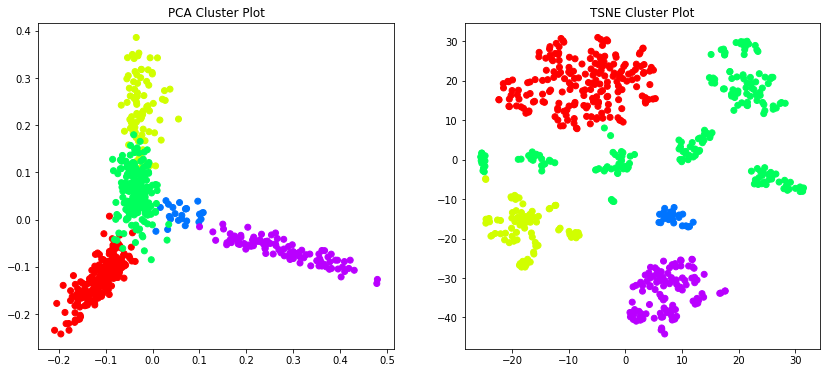

In [ ]:
plot_tsne_pca(pca,tsne, books_df['author_code'].values)

In [ ]:
get_clusters_label(books_df.author_code,books_df.author)

,,actual_labels
clusters,actual_labels,
0.0,Jane Austen,100.0
1.0,Lewis Carroll and Alice Gerstenberg,100.0
2.0,Maria Edgeworth,100.0
3.0,William Blake,100.0
4.0,William Shakespeare,100.0


## **Kmeans using TFIDF**

In [ ]:
pca_tfidf,tsne_tfidf=tsne_pca(tfidf, books_df['author_code'].values,n_c=50,flag="dense")

For n_clusters = 2 The average silhouette_score is : 0.5636698802212871
For n_clusters = 3 The average silhouette_score is : 0.5997802639991326
For n_clusters = 4 The average silhouette_score is : 0.6037857646846974
For n_clusters = 5 The average silhouette_score is : 0.5844936630289458
For n_clusters = 6 The average silhouette_score is : 0.5185202378040548
For n_clusters = 7 The average silhouette_score is : 0.47599716819445775
For n_clusters = 8 The average silhouette_score is : 0.4842630552235686
For n_clusters = 9 The average silhouette_score is : 0.47072496475880826
For n_clusters = 10 The average silhouette_score is : 0.46625884551926805
For n_clusters = 11 The average silhouette_score is : 0.4300243883197283
For n_clusters = 12 The average silhouette_score is : 0.4067811685949052
For n_clusters = 13 The average silhouette_score is : 0.4042786367265016
For n_clusters = 14 The average silhouette_score is : 0.39852174703197885


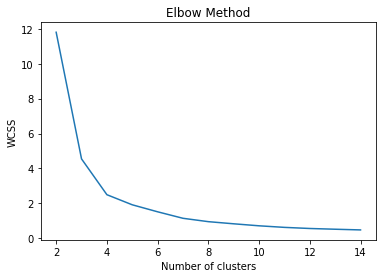

In [ ]:
optimum_k(max_k=15,X=pca_tfidf)

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters_tfidf=kmeans.fit_predict(pca_tfidf)

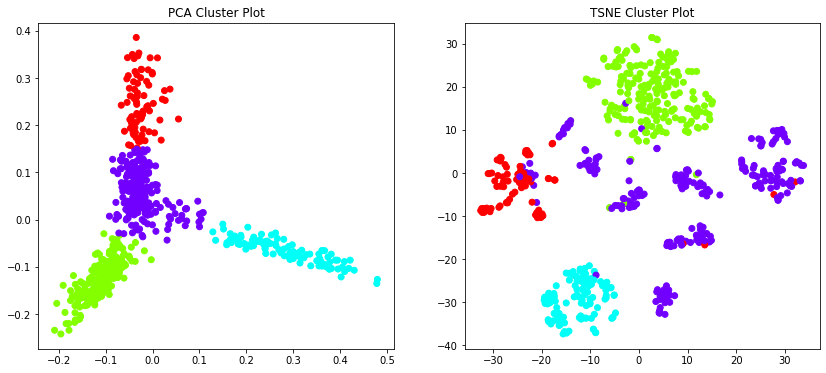

In [ ]:
plot_tsne_pca(pca_tfidf,tsne_tfidf,clusters_tfidf)

In [ ]:
get_clusters_label(clusters_tfidf,books_df.author)

actual_labels
clusters actual_labels                                     
0        Lewis Carroll and Alice Gerstenberg      94.871795
         Maria Edgeworth                           5.128205
1        Jane Austen                              97.044335
         Maria Edgeworth                           2.955665
2        William Shakespeare                     100.000000
3        Maria Edgeworth                          84.000000
         William Blake                            10.666667
         Lewis Carroll and Alice Gerstenberg       4.000000
         Jane Austen                               0.888889
         William Shakespeare                       0.444444

In [ ]:
pd.DataFrame(evaluate_cluster_labels(get_clusters_label(clusters_tfidf,books_df.author)))

,cluster,label,percentage
0,0,Lewis Carroll and Alice Gerstenberg,94.871795
1,1,Jane Austen,97.044335
2,2,William Shakespeare,100.000000
3,3,Maria Edgeworth,84.000000


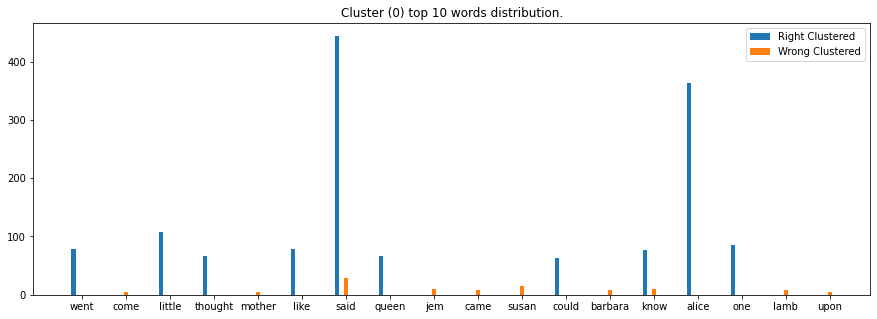

Top 10 words in the right clustered
 [('said', 444), ('alice', 363), ('little', 108), ('one', 85), ('like', 79), ('went', 78), ('know', 76), ('queen', 67), ('thought', 66), ('could', 63)]

Top 10 words in the wrong clustered
 [('said', 29), ('susan', 15), ('jem', 10), ('know', 10), ('came', 9), ('barbara', 8), ('lamb', 8), ('mother', 5), ('come', 5), ('upon', 5)]

Found 2 words in both right and wrong clustered top words [('said', 29), ('know', 10)]




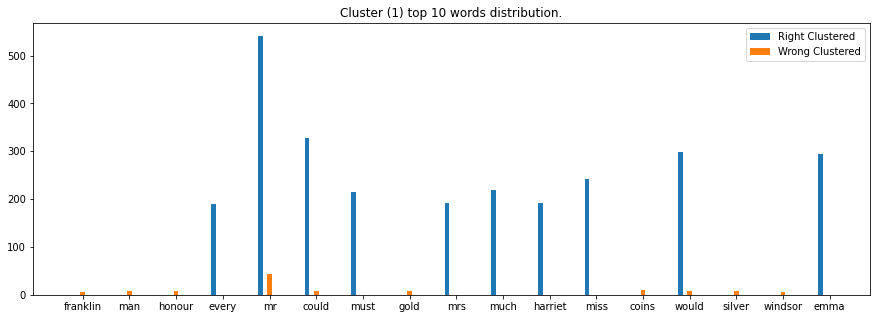

Top 10 words in the right clustered
 [('mr', 541), ('could', 328), ('would', 298), ('emma', 294), ('miss', 242), ('much', 218), ('must', 215), ('mrs', 192), ('harriet', 192), ('every', 189)]

Top 10 words in the wrong clustered
 [('mr', 43), ('coins', 9), ('could', 8), ('gold', 8), ('silver', 8), ('would', 7), ('man', 7), ('honour', 7), ('franklin', 6), ('windsor', 6)]

Found 3 words in both right and wrong clustered top words [('mr', 43), ('could', 8), ('would', 7)]




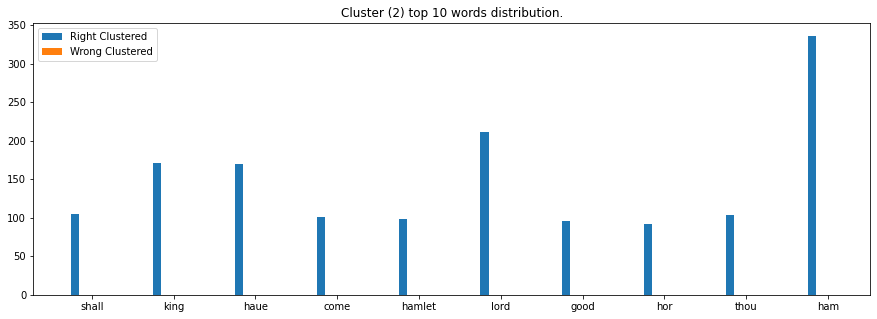

Top 10 words in the right clustered
 [('ham', 336), ('lord', 211), ('king', 171), ('haue', 170), ('shall', 105), ('thou', 104), ('come', 101), ('hamlet', 98), ('good', 96), ('hor', 92)]

Top 10 words in the wrong clustered
 []

Found 0 words in both right and wrong clustered top words []




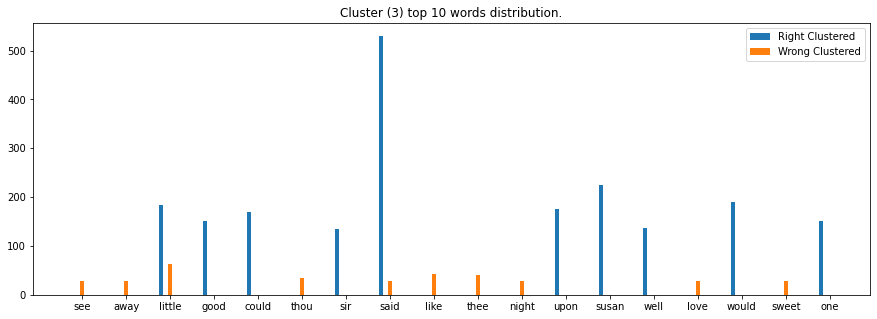

Top 10 words in the right clustered
 [('said', 530), ('susan', 225), ('would', 189), ('little', 183), ('upon', 175), ('could', 170), ('one', 152), ('good', 152), ('well', 136), ('sir', 134)]

Top 10 words in the wrong clustered
 [('little', 63), ('like', 43), ('thee', 41), ('thou', 34), ('away', 29), ('see', 29), ('night', 29), ('said', 28), ('sweet', 28), ('love', 28)]

Found 2 words in both right and wrong clustered top words [('little', 63), ('said', 28)]




In [ ]:
top_frequent_analysis(clusters_tfidf,books_df.author,books_df.partition)

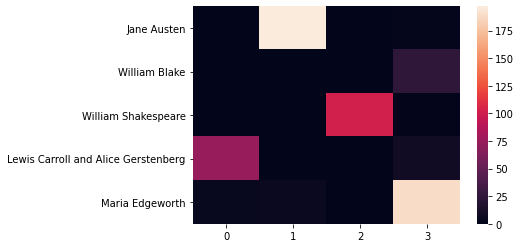

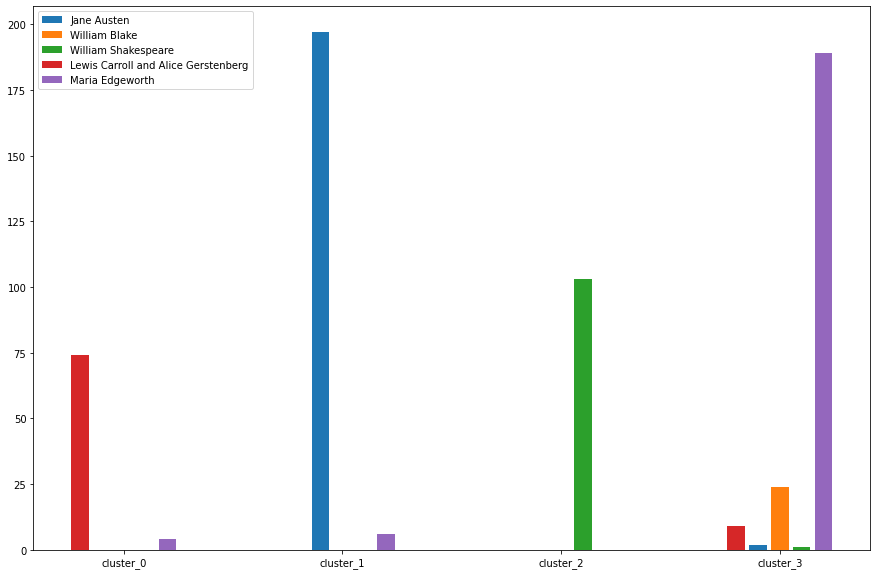

,0,1,2,3,label
0,0,197,0,2,Jane Austen
1,0,0,0,24,William Blake
2,0,0,103,1,William Shakespeare
3,74,0,0,9,Lewis Carroll and Alice Gerstenberg
4,4,6,0,189,Maria Edgeworth


In [ ]:
cluster_labels_dist_plot(clusters_tfidf , books_df.author)

### Performance Evaluations

In [ ]:
labels_tfidf=map_actual_labels(clusters_tfidf,books_df.author)

In [ ]:
calculate_metrics(books_df.author,labels_tfidf,pca_tfidf)

Homogeneity score:  0.8
Completeness score:  0.88
V-measure score:  0.84
Adjusted rand score:  0.84
Kappa score:  0.94
Silhouette score:  0.6
Correlation:  SpearmanrResult(correlation=0.964462909709061, pvalue=0.0)


## **Kmeans on BOW**

In [ ]:
pca_bow,tsne_bow=tsne_pca(bow, books_df['author_code'].values,n_c=50,flag="dense")

For n_clusters = 2 The average silhouette_score is : 0.4081058616204316
For n_clusters = 3 The average silhouette_score is : 0.5267658702118485
For n_clusters = 4 The average silhouette_score is : 0.5146432529800337
For n_clusters = 5 The average silhouette_score is : 0.4866257153573197
For n_clusters = 6 The average silhouette_score is : 0.48184950740654947
For n_clusters = 7 The average silhouette_score is : 0.44475082003914035
For n_clusters = 8 The average silhouette_score is : 0.41918429833802745
For n_clusters = 9 The average silhouette_score is : 0.4171427952243414
For n_clusters = 10 The average silhouette_score is : 0.414081097556861
For n_clusters = 11 The average silhouette_score is : 0.4044782129400175
For n_clusters = 12 The average silhouette_score is : 0.40113902882087593
For n_clusters = 13 The average silhouette_score is : 0.41405253292144373
For n_clusters = 14 The average silhouette_score is : 0.40825115876662094


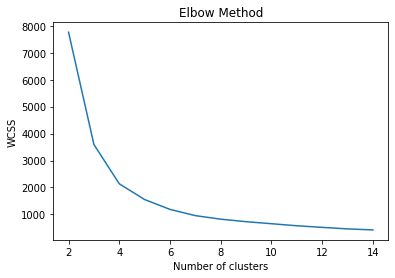

In [ ]:
optimum_k(max_k=15,X=pca_bow)

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters_bow = kmeans.fit_predict(pca_bow)

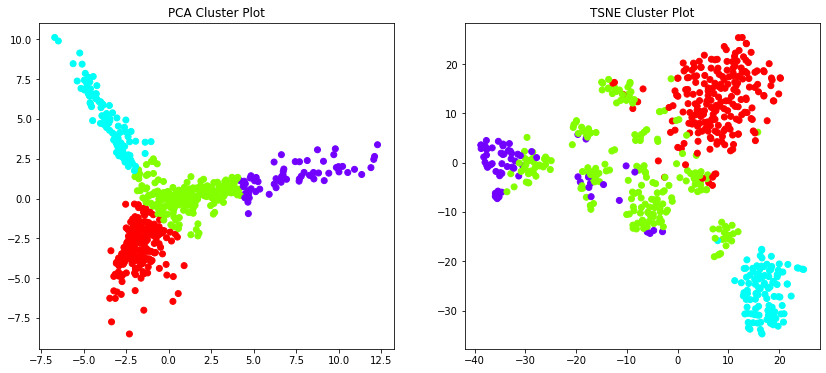

In [ ]:
plot_tsne_pca(pca_bow,tsne_bow,clusters_bow)

In [ ]:
get_clusters_label(clusters_bow ,books_df.author)

actual_labels
clusters actual_labels                                     
0        Jane Austen                              89.671362
         Maria Edgeworth                           9.859155
         William Blake                             0.469484
1        Maria Edgeworth                          72.000000
         Lewis Carroll and Alice Gerstenberg      14.666667
         William Blake                             9.777778
         Jane Austen                               3.555556
2        William Shakespeare                      99.047619
         William Blake                             0.952381
3        Lewis Carroll and Alice Gerstenberg      75.757576
         Maria Edgeworth                          24.242424

In [ ]:
pd.DataFrame(evaluate_cluster_labels(get_clusters_label(clusters_bow ,books_df.author)))

,cluster,label,percentage
0,0,Jane Austen,89.671362
1,1,Maria Edgeworth,72.000000
2,2,William Shakespeare,99.047619
3,3,Lewis Carroll and Alice Gerstenberg,75.757576


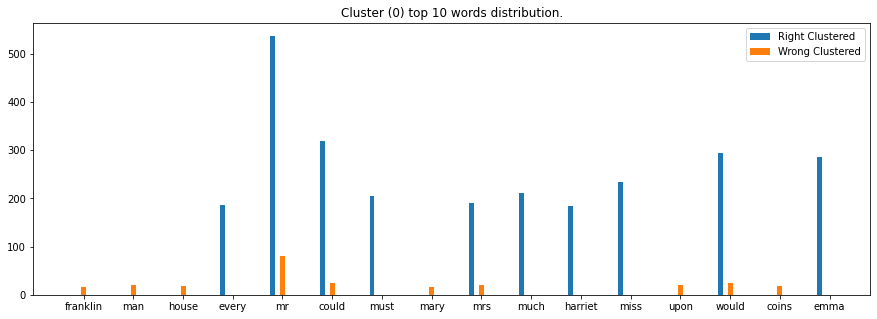

Top 10 words in the right clustered
 [('mr', 537), ('could', 319), ('would', 294), ('emma', 285), ('miss', 234), ('much', 211), ('must', 204), ('mrs', 190), ('every', 186), ('harriet', 185)]

Top 10 words in the wrong clustered
 [('mr', 80), ('could', 25), ('would', 24), ('upon', 21), ('man', 20), ('mrs', 20), ('house', 19), ('coins', 18), ('mary', 17), ('franklin', 16)]

Found 4 words in both right and wrong clustered top words [('mr', 80), ('could', 25), ('would', 24), ('mrs', 20)]




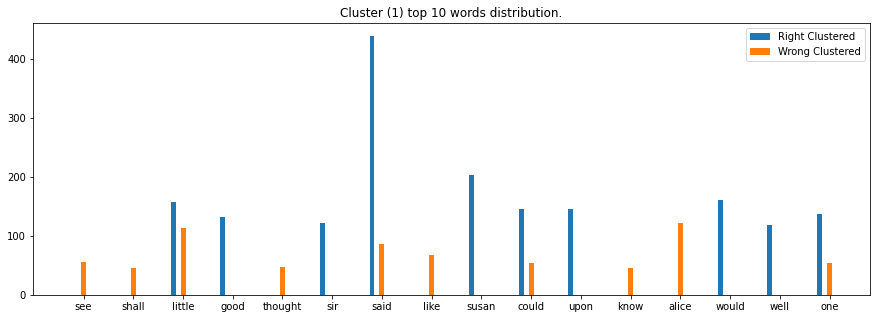

Top 10 words in the right clustered
 [('said', 439), ('susan', 204), ('would', 160), ('little', 158), ('could', 146), ('upon', 145), ('one', 137), ('good', 132), ('sir', 122), ('well', 119)]

Top 10 words in the wrong clustered
 [('alice', 122), ('little', 113), ('said', 87), ('like', 68), ('see', 55), ('could', 54), ('one', 54), ('thought', 47), ('know', 46), ('shall', 45)]

Found 4 words in both right and wrong clustered top words [('little', 113), ('said', 87), ('could', 54), ('one', 54)]




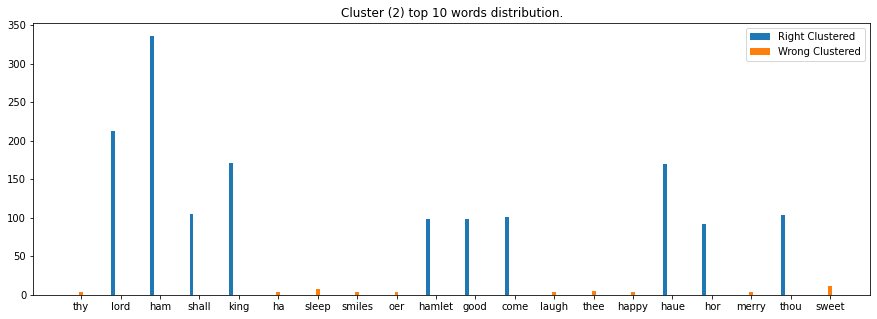

Top 10 words in the right clustered
 [('ham', 336), ('lord', 212), ('king', 171), ('haue', 170), ('shall', 105), ('thou', 104), ('come', 101), ('hamlet', 98), ('good', 98), ('hor', 92)]

Top 10 words in the wrong clustered
 [('sweet', 12), ('sleep', 7), ('thee', 5), ('ha', 4), ('happy', 4), ('smiles', 4), ('laugh', 3), ('merry', 3), ('oer', 3), ('thy', 3)]

Found 0 words in both right and wrong clustered top words []




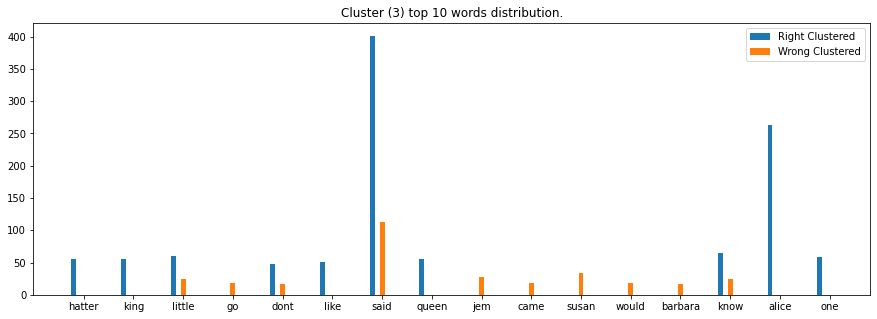

Top 10 words in the right clustered
 [('said', 401), ('alice', 263), ('know', 65), ('little', 60), ('one', 58), ('queen', 56), ('hatter', 55), ('king', 55), ('like', 51), ('dont', 48)]

Top 10 words in the wrong clustered
 [('said', 113), ('susan', 34), ('jem', 28), ('know', 25), ('little', 24), ('would', 19), ('go', 19), ('came', 18), ('dont', 17), ('barbara', 16)]

Found 4 words in both right and wrong clustered top words [('said', 113), ('know', 25), ('little', 24), ('dont', 17)]




In [ ]:
top_frequent_analysis(clusters_bow,books_df.author,books_df.partition)

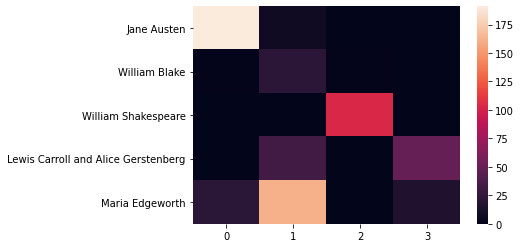

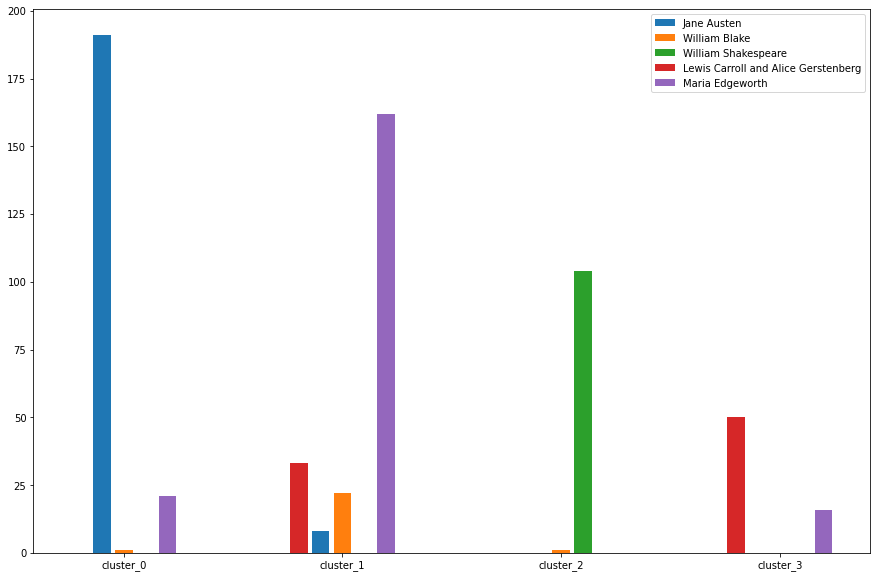

,0,1,2,3,label
0,191,8,0,0,Jane Austen
1,1,22,1,0,William Blake
2,0,0,104,0,William Shakespeare
3,0,33,0,50,Lewis Carroll and Alice Gerstenberg
4,21,162,0,16,Maria Edgeworth


In [ ]:
cluster_labels_dist_plot(clusters_bow , books_df.author)

### Performance Evaluation

In [ ]:
labels_bow=map_actual_labels(clusters_bow,books_df.author)

In [ ]:
calculate_metrics(books_df.author,labels_bow,pca_bow)

Homogeneity score:  0.64
Completeness score:  0.72
V-measure score:  0.68
Adjusted rand score:  0.65
Kappa score:  0.86
Silhouette score:  0.51
Correlation:  SpearmanrResult(correlation=0.8915495481179373, pvalue=5.844342575999769e-211)


## **Kmeans on Word Embeddings**

In [ ]:
pca_emb,tsne_emb=tsne_pca(word_emb, books_df['author_code'].values,n_c=50)

For n_clusters = 2 The average silhouette_score is : 0.604696
For n_clusters = 3 The average silhouette_score is : 0.49197975
For n_clusters = 4 The average silhouette_score is : 0.45046747
For n_clusters = 5 The average silhouette_score is : 0.38390592
For n_clusters = 6 The average silhouette_score is : 0.39759043
For n_clusters = 7 The average silhouette_score is : 0.36130068
For n_clusters = 8 The average silhouette_score is : 0.35356638
For n_clusters = 9 The average silhouette_score is : 0.34769538
For n_clusters = 10 The average silhouette_score is : 0.3502234
For n_clusters = 11 The average silhouette_score is : 0.35525978
For n_clusters = 12 The average silhouette_score is : 0.35052758
For n_clusters = 13 The average silhouette_score is : 0.33854643
For n_clusters = 14 The average silhouette_score is : 0.34778282


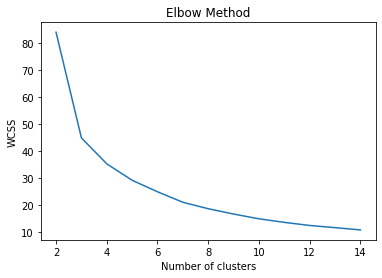

In [ ]:
optimum_k(max_k=15,X=pca_emb)

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters_emb = kmeans.fit_predict(pca_emb)

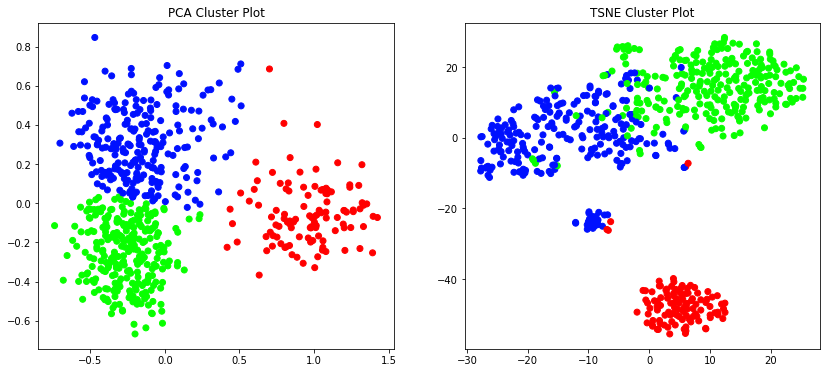

In [ ]:
plot_tsne_pca(pca_emb,tsne_emb,clusters_emb)

In [ ]:
get_clusters_label(clusters_emb,books_df.author)

actual_labels
clusters actual_labels                                     
0        William Shakespeare                      95.412844
         William Blake                             2.752294
         Maria Edgeworth                           1.834862
1        Jane Austen                              74.242424
         Maria Edgeworth                          23.863636
         Lewis Carroll and Alice Gerstenberg       1.893939
2        Maria Edgeworth                          56.779661
         Lewis Carroll and Alice Gerstenberg      33.050847
         William Blake                             8.898305
         Jane Austen                               1.271186

In [ ]:
pd.DataFrame(evaluate_cluster_labels(get_clusters_label(clusters_emb,books_df.author)))

,cluster,label,percentage
0,0,William Shakespeare,95.412844
1,1,Jane Austen,74.242424
2,2,Maria Edgeworth,56.779661


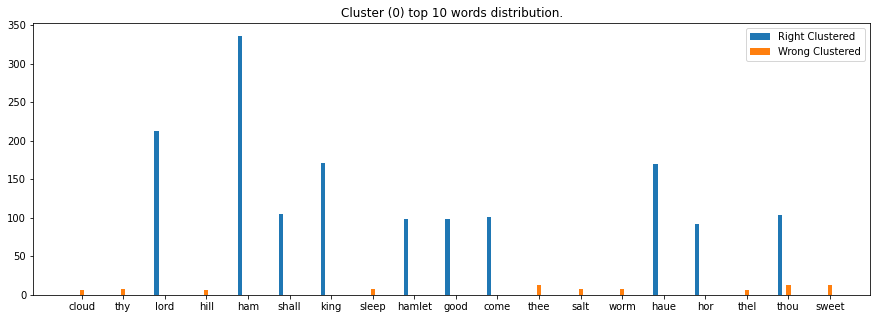

Top 10 words in the right clustered
 [('ham', 336), ('lord', 212), ('king', 171), ('haue', 170), ('shall', 105), ('thou', 104), ('come', 101), ('hamlet', 98), ('good', 98), ('hor', 92)]

Top 10 words in the wrong clustered
 [('sweet', 13), ('thee', 13), ('thou', 13), ('salt', 8), ('sleep', 7), ('thy', 7), ('worm', 7), ('hill', 6), ('thel', 6), ('cloud', 6)]

Found 1 words in both right and wrong clustered top words [('thou', 13)]




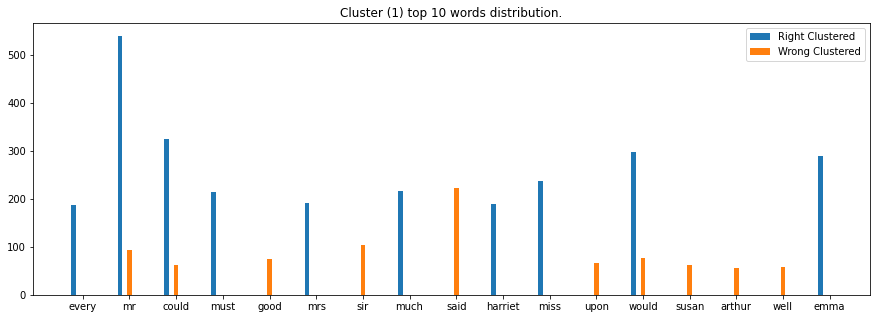

Top 10 words in the right clustered
 [('mr', 540), ('could', 325), ('would', 297), ('emma', 290), ('miss', 238), ('much', 217), ('must', 214), ('mrs', 191), ('harriet', 190), ('every', 188)]

Top 10 words in the wrong clustered
 [('said', 222), ('sir', 104), ('mr', 94), ('would', 76), ('good', 75), ('upon', 67), ('could', 63), ('susan', 62), ('well', 57), ('arthur', 56)]

Found 3 words in both right and wrong clustered top words [('mr', 94), ('would', 76), ('could', 63)]




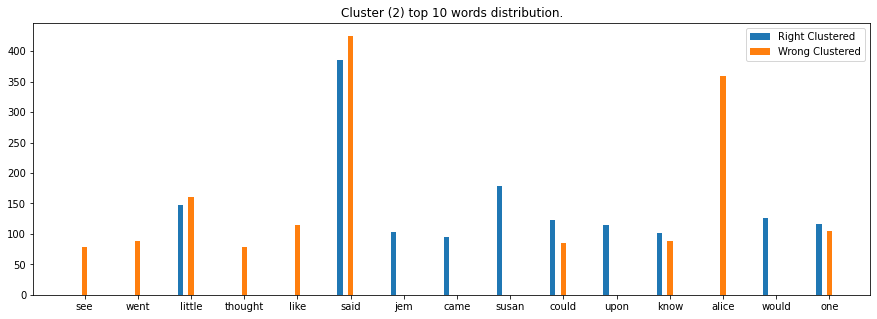

Top 10 words in the right clustered
 [('said', 386), ('susan', 178), ('little', 148), ('would', 126), ('could', 122), ('one', 117), ('upon', 114), ('jem', 103), ('know', 102), ('came', 95)]

Top 10 words in the wrong clustered
 [('said', 425), ('alice', 360), ('little', 161), ('like', 115), ('one', 104), ('know', 89), ('went', 88), ('could', 85), ('thought', 79), ('see', 78)]

Found 5 words in both right and wrong clustered top words [('said', 425), ('little', 161), ('one', 104), ('know', 89), ('could', 85)]




In [ ]:
top_frequent_analysis(clusters_emb,books_df.author,books_df.partition)

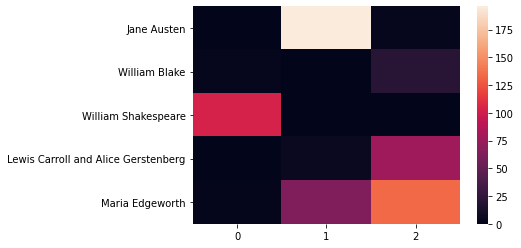

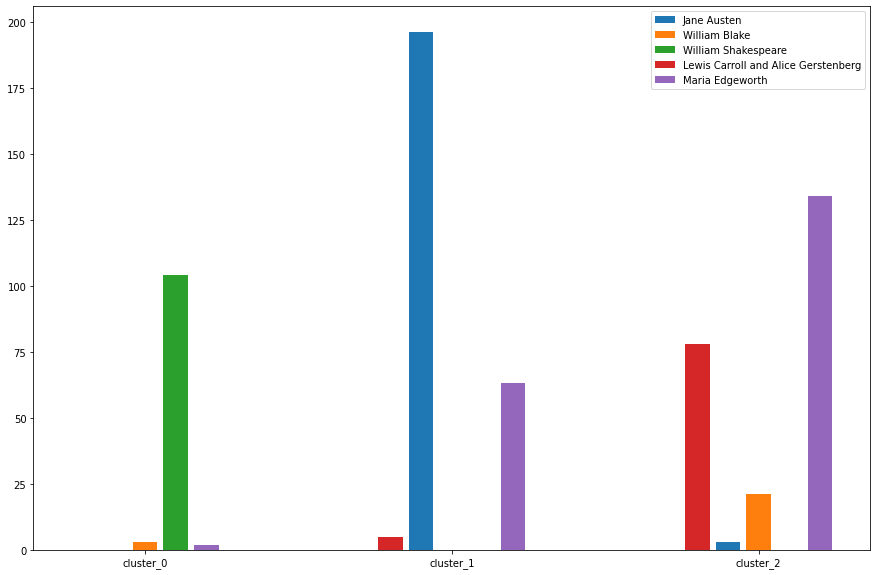

,0,1,2,label
0,0,196,3,Jane Austen
1,3,0,21,William Blake
2,104,0,0,William Shakespeare
3,0,5,78,Lewis Carroll and Alice Gerstenberg
4,2,63,134,Maria Edgeworth


In [ ]:
cluster_labels_dist_plot(clusters_emb , books_df.author)

###Performance Evaluation

In [ ]:
labels_emb=map_actual_labels(clusters_emb,books_df.author)

In [ ]:
calculate_metrics(books_df.author,labels_emb,pca_emb)

Homogeneity score:  0.52
Completeness score:  0.72
V-measure score:  0.6
Adjusted rand score:  0.51
Kappa score:  0.75
Silhouette score:  0.49
Correlation:  SpearmanrResult(correlation=0.8116836749843404, pvalue=7.193000751979694e-144)


##**Kmeans on LDA**

In [ ]:
pca_lda,tsne_lda=tsne_pca(lda, books_df['author_code'].values,n_c=20)

For n_clusters = 2 The average silhouette_score is : 0.59654266
For n_clusters = 3 The average silhouette_score is : 0.4846462
For n_clusters = 4 The average silhouette_score is : 0.419097
For n_clusters = 5 The average silhouette_score is : 0.41661885
For n_clusters = 6 The average silhouette_score is : 0.39479074
For n_clusters = 7 The average silhouette_score is : 0.378408
For n_clusters = 8 The average silhouette_score is : 0.38687485
For n_clusters = 9 The average silhouette_score is : 0.363436
For n_clusters = 10 The average silhouette_score is : 0.35294938
For n_clusters = 11 The average silhouette_score is : 0.3639313
For n_clusters = 12 The average silhouette_score is : 0.35619617
For n_clusters = 13 The average silhouette_score is : 0.36170867
For n_clusters = 14 The average silhouette_score is : 0.37176546
For n_clusters = 15 The average silhouette_score is : 0.3606562
For n_clusters = 16 The average silhouette_score is : 0.36040717
For n_clusters = 17 The average silhouette

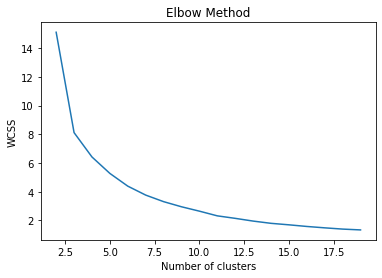

In [ ]:
optimum_k(max_k=20,X=pca_lda)

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters_lda = kmeans.fit_predict(pca_lda)

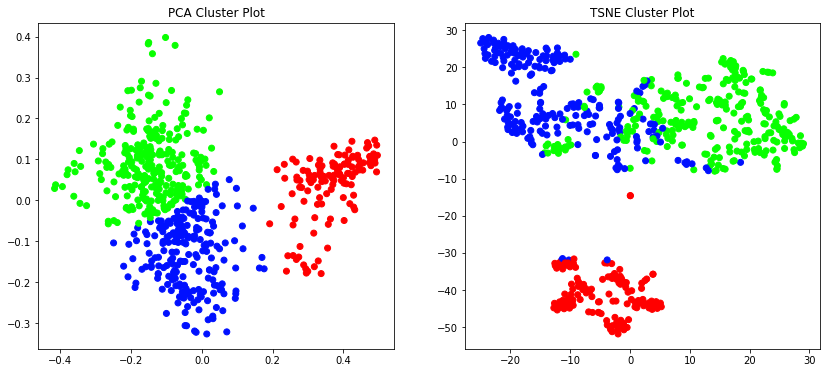

In [ ]:
plot_tsne_pca(pca_lda,tsne_lda,clusters_lda)

In [ ]:
get_clusters_label(clusters_lda,books_df.author)

actual_labels
clusters actual_labels                                     
0        William Shakespeare                      81.250000
         William Blake                            15.625000
         Maria Edgeworth                           3.125000
1        Jane Austen                              74.809160
         Maria Edgeworth                          25.190840
2        Maria Edgeworth                          58.904110
         Lewis Carroll and Alice Gerstenberg      37.899543
         William Blake                             1.826484
         Jane Austen                               1.369863

In [ ]:
pd.DataFrame(evaluate_cluster_labels(get_clusters_label(clusters_lda,books_df.author)))

,cluster,label,percentage
0,0,William Shakespeare,81.25000
1,1,Jane Austen,74.80916
2,2,Maria Edgeworth,58.90411


###Performance Evaluation

In [ ]:
labels_lda= map_actual_labels(clusters_lda, books_df.author)

In [ ]:
calculate_metrics(books_df.author,labels_lda,pca_lda)

Homogeneity score:  0.54
Completeness score:  0.74
V-measure score:  0.62
Adjusted rand score:  0.53
Kappa score:  0.74
Silhouette score:  0.48
Correlation:  SpearmanrResult(correlation=0.8152249366079647, pvalue=4.075503319969094e-146)


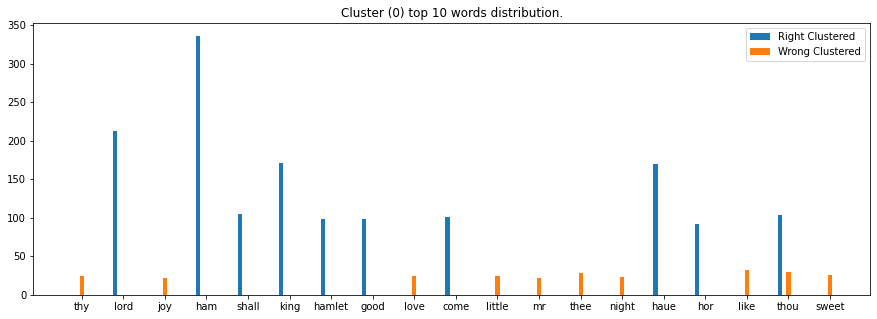

Top 10 words in the right clustered
 [('ham', 336), ('lord', 212), ('king', 171), ('haue', 170), ('shall', 105), ('thou', 104), ('come', 101), ('hamlet', 98), ('good', 98), ('hor', 92)]

Top 10 words in the wrong clustered
 [('like', 32), ('thou', 30), ('thee', 28), ('sweet', 26), ('thy', 25), ('little', 24), ('love', 24), ('night', 23), ('joy', 22), ('mr', 22)]

Found 1 words in both right and wrong clustered top words [('thou', 30)]




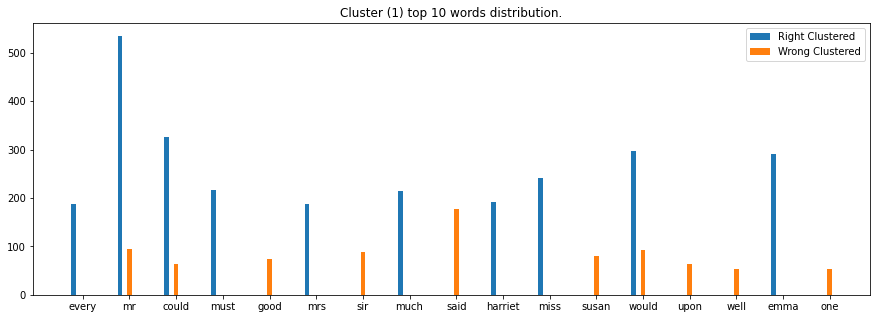

Top 10 words in the right clustered
 [('mr', 535), ('could', 327), ('would', 297), ('emma', 290), ('miss', 242), ('must', 216), ('much', 214), ('harriet', 191), ('every', 188), ('mrs', 188)]

Top 10 words in the wrong clustered
 [('said', 177), ('mr', 95), ('would', 93), ('sir', 89), ('susan', 80), ('good', 75), ('upon', 64), ('could', 63), ('well', 54), ('one', 53)]

Found 3 words in both right and wrong clustered top words [('mr', 95), ('would', 93), ('could', 63)]




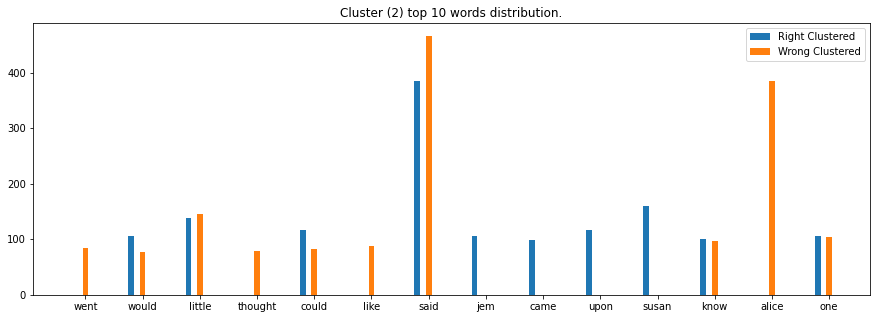

Top 10 words in the right clustered
 [('said', 385), ('susan', 160), ('little', 138), ('could', 117), ('upon', 116), ('one', 106), ('would', 105), ('jem', 105), ('know', 100), ('came', 99)]

Top 10 words in the wrong clustered
 [('said', 466), ('alice', 385), ('little', 146), ('one', 104), ('know', 96), ('like', 88), ('went', 84), ('could', 82), ('thought', 78), ('would', 77)]

Found 6 words in both right and wrong clustered top words [('said', 466), ('little', 146), ('one', 104), ('know', 96), ('could', 82), ('would', 77)]




In [ ]:
top_frequent_analysis(clusters_lda,books_df.author,books_df.partition)

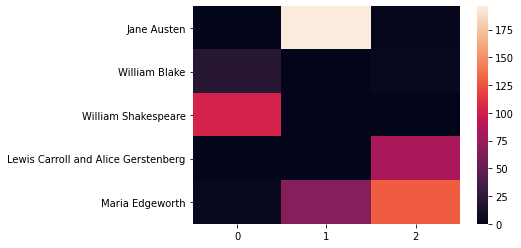

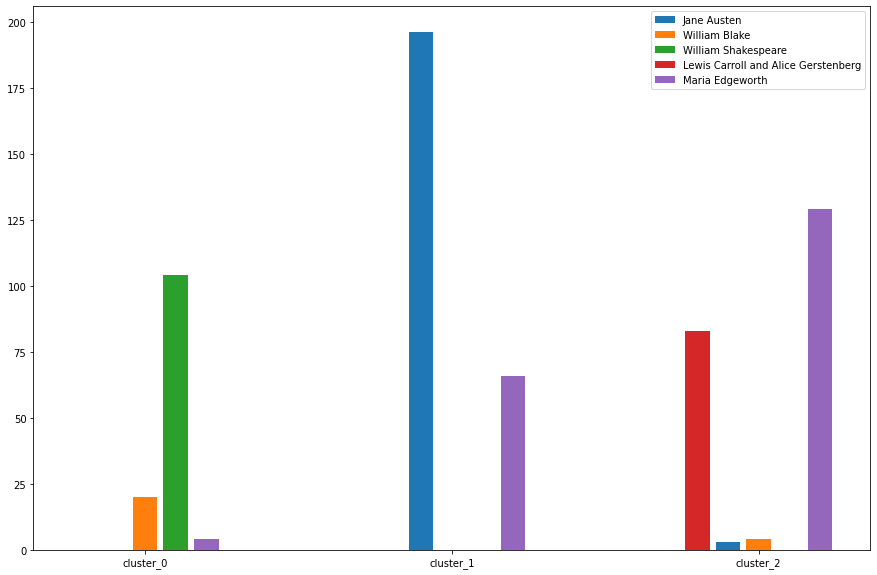

,0,1,2,label
0,0,196,3,Jane Austen
1,20,0,4,William Blake
2,104,0,0,William Shakespeare
3,0,0,83,Lewis Carroll and Alice Gerstenberg
4,4,66,129,Maria Edgeworth


In [ ]:
cluster_labels_dist_plot(clusters_lda , books_df.author)